In [1]:
#Import modules
%matplotlib inline
import pandas as pd
import numpy as np
import fnmatch
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importerer datasettet fra github
url = "https://raw.githubusercontent.com/umaimehm/Intro_to_AI_2021/main/assignment1/Ruter_data.csv"

In [3]:
#Definerer datasettet
df = pd.read_csv(url, sep=';')

In [4]:
#Sjekker datasettet for å få oversikt og se at det fungerte
df.head()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord
0,15006-2020-08-10T10:24:00+02:00,10/08/2020,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,0,10:53:53,10:53:59,10:53:00,10:53:00,112,5
1,15002-2020-08-15T12:54:00+02:00,15/08/2020,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,0,13:12:20,13:12:26,13:12:00,13:12:00,112,5
2,15004-2020-08-03T09:54:00+02:00,03/08/2020,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,0,10:18:56,10:19:21,10:19:00,10:19:00,112,6
3,15003-2020-07-27T13:00:00+02:00,27/07/2020,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,1,13:52:04,13:52:26,13:51:00,13:51:00,112,10
4,15002-2020-08-27T07:15:00+02:00,27/08/2020,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,1,07:34:13,07:34:53,07:33:00,07:33:00,112,10


In [5]:
#Sjekke info og datatyper
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   TurId                                      6000 non-null   object
 1   Dato                                       6000 non-null   object
 2   Fylke                                      6000 non-null   object
 3   Område                                     6000 non-null   object
 4   Kommune                                    6000 non-null   object
 5   Holdeplass_Fra                             6000 non-null   object
 6   Holdeplass_Til                             6000 non-null   object
 7   Linjetype                                  6000 non-null   object
 8   Linjefylke                                 6000 non-null   object
 9   Linjenavn                                  6000 non-null   object
 10  Linjeretning                        

In [6]:
#Ser etter manglende data i Faktisk ankomst/avgang og fjerner det
df["Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra"].replace(':', np.nan, inplace=True);
df["Tidspunkt_Faktisk_Avgang_Holdeplass_Fra"].replace(':', np.nan, inplace=True);
df.isna().sum()

TurId                                         0
Dato                                          0
Fylke                                         0
Område                                        0
Kommune                                       0
Holdeplass_Fra                                0
Holdeplass_Til                                0
Linjetype                                     0
Linjefylke                                    0
Linjenavn                                     0
Linjeretning                                  0
Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra     50
Tidspunkt_Faktisk_Avgang_Holdeplass_Fra       1
Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra     0
Tidspunkt_Planlagt_Avgang_Holdeplass_Fra      0
Kjøretøy_Kapasitet                            0
Passasjerer_Ombord                            0
dtype: int64

In [7]:
#Sletter manglende data
df.dropna(inplace = True);

In [8]:
#Legger til Forsinkelse
df["Forsinkelse"] = pd.to_timedelta(df['Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra']) - pd.to_timedelta(df['Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra'])

In [9]:
#Legger til Stopptid
df["Stopptid"] = pd.to_timedelta(df['Tidspunkt_Faktisk_Avgang_Holdeplass_Fra']) - pd.to_timedelta(df['Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra'])

In [10]:
#Konverterer timedelta til antall sekunder
def to_seconds(x):
    return x.total_seconds()


df["Forsinkelse"] = df["Forsinkelse"].apply(to_seconds).astype('int32')
df["Stopptid"] = df["Stopptid"].apply(to_seconds).astype('int32')

In [11]:
#Lager funksjon for å sjekke om klokka er mellom 7 og 9  eller 15 og 18 og definerer dette som rushtid
def isrushtid(x):
    if x.startswith('24') or x.startswith('25'): return 0
    time = pd.Timestamp(x).hour
    if time > 6 and time < 9:
            return 1
    elif time > 14 and time < 18:
            return 1
    else: return 0

In [12]:
#Legger til Rushtid
df['Rushtid'] = df['Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra'].apply(isrushtid)

In [13]:
#Sjekke at alt ble riktig
df.head(10)

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord,Forsinkelse,Stopptid,Rushtid
0,15006-2020-08-10T10:24:00+02:00,10/08/2020,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,0,10:53:53,10:53:59,10:53:00,10:53:00,112,5,53,6,0
1,15002-2020-08-15T12:54:00+02:00,15/08/2020,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,0,13:12:20,13:12:26,13:12:00,13:12:00,112,5,20,6,0
2,15004-2020-08-03T09:54:00+02:00,03/08/2020,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,0,10:18:56,10:19:21,10:19:00,10:19:00,112,6,-4,25,0
3,15003-2020-07-27T13:00:00+02:00,27/07/2020,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,1,13:52:04,13:52:26,13:51:00,13:51:00,112,10,64,22,0
4,15002-2020-08-27T07:15:00+02:00,27/08/2020,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,1,07:34:13,07:34:53,07:33:00,07:33:00,112,10,73,40,1
5,3110-2020-08-01T16:16:00+02:00,01/08/2020,Oslo,Nordøst,Bjerke,Veitvet (mot Kalbakken),Rødtvet (mot Kalbakken),Lokal,Oslo,31,0,17:22:56,17:23:23,17:16:00,17:16:00,151,8,416,27,1
6,15010-2020-07-28T13:09:00+02:00,28/07/2020,Viken,Vest,Bærum,Nedre Toppenhaug,Øvre Toppenhaug,Lokal,Viken,150,0,13:19:00,13:19:05,13:17:00,13:17:00,112,1,120,5,0
7,15003-2020-07-27T06:18:00+02:00,27/07/2020,Oslo,Indre By,St.Hanshaugen,Hammersborggata (ved Storgata retning vest),St. Olavs plass (mot Frederiks gate),Lokal,Viken,150,1,06:20:24,06:20:29,06:20:00,06:20:00,112,-1,24,5,0
8,21002-2020-08-16T14:33:00+02:00,16/08/2020,Viken,Vest,Bærum,Stein gård,Knabberudveien,Lokal,Viken,150,1,15:10:12,15:10:34,15:09:00,15:09:00,112,2,72,22,1
9,15002-2020-08-13T18:09:00+02:00,13/08/2020,Viken,Vest,Bærum,Bekkestua bussterminal (Plattform C),Stabekk skole,Lokal,Viken,150,0,18:37:41,18:38:19,18:29:00,18:29:00,112,4,521,38,0


In [14]:
#Lager gruppering for linjetype
linjeType = df.groupby(["Linjetype"])

<AxesSubplot:title={'center':'Gjennomsnittlig forsinkelse per linjetype'}, xlabel='Linjetype', ylabel='Tid i sekunder'>

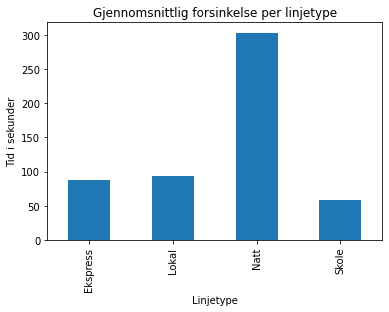

In [15]:
#Lager graf over Forsinkelse per linjetype
linjeType["Forsinkelse"].mean().plot(title='Gjennomsnittlig forsinkelse per linjetype', ylabel='Tid i sekunder' ,kind="bar")

In [16]:
#Lager gruppering over rushtid
rushtid = df.groupby(["Rushtid"])

<AxesSubplot:title={'center':'Forsinkelse i rushtid'}, xlabel='Rushtid', ylabel='Tid i sekunder'>

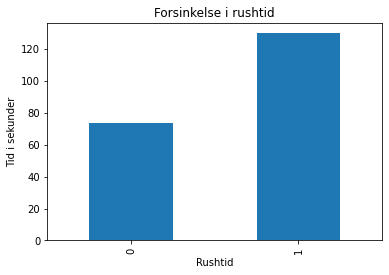

In [17]:
#Lager graf over Forsinkelse i rushtiden
rushtid["Forsinkelse"].mean().plot(title='Forsinkelse i rushtid', ylabel='Tid i sekunder' ,kind="bar")

<AxesSubplot:title={'center':'Stopptid i rushtid'}, xlabel='Rushtid', ylabel='Tid i sekunder'>

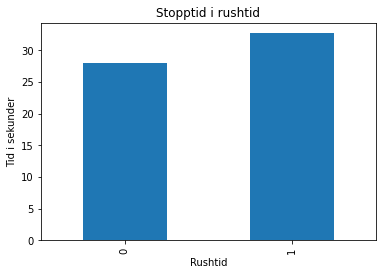

In [18]:
#Lager graf over stopptid i rushtiden
rushtid["Stopptid"].mean().plot(title='Stopptid i rushtid', ylabel='Tid i sekunder', kind="bar")

<AxesSubplot:>

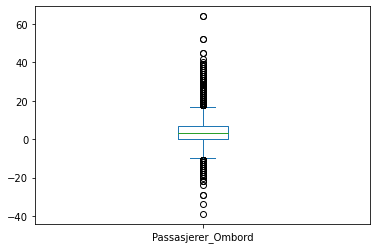

In [19]:
#Sjekker uteliggere i kolonne Passasjerer_Ombord
df["Passasjerer_Ombord"].plot.box()

In [20]:
#Definerer en variabel for alle verdier under null i kolonne Passasjerer_Ombord
negValue = df[df["Passasjerer_Ombord"] < 0].index

In [21]:
#Sletter alle rader med negativ verdi i Passasjerer_Ombord
df.drop(negValue, inplace = True)

<AxesSubplot:>

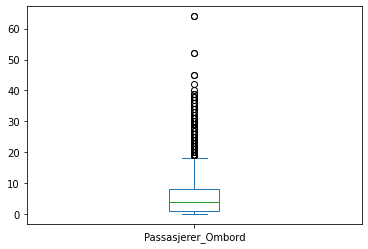

In [22]:
#Sjekker plotbox igjen for å se at de ble slettet
df["Passasjerer_Ombord"].plot.box()

In [23]:
#Resetter index etter sletting
df = df.reset_index(drop=True)
df.tail()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord,Forsinkelse,Stopptid,Rushtid
5285,12001-2020-06-02T23:15:00+02:00,02/06/2020,Viken,Nordøst,Rælingen,Kurlandsveien,Frydenbergveien,Lokal,Viken,310,0,23:29:01,23:29:05,23:27:00,23:27:00,72,0,121,4,0
5286,10001-2020-06-10T15:10:00+02:00,10/06/2020,Viken,Nordøst,Lillestrøm,Brauterkrysset,Nordsnoveien,Lokal,Viken,100,1,16:23:18,16:23:48,16:10:00,16:10:00,151,2,798,30,1
5287,10010-2020-06-23T05:54:00+02:00,23/06/2020,Viken,Nordøst,Lillestrøm,Vestbygata,Bjørnsons gate,Lokal,Viken,100,0,06:00:32,06:00:40,05:59:00,05:59:00,151,2,92,8,0
5288,2007-2020-06-11T17:22:00+02:00,11/06/2020,Oslo,Indre By,Sagene,Torshovparken (mot Torshovparken),Torshov (mot Bentsebrua),Lokal,Oslo,20,1,17:42:43,17:43:10,17:32:00,17:32:00,106,3,643,27,1
5289,10004-2020-08-13T04:59:00+02:00,13/08/2020,Oslo,Indre By,Gamle Oslo,Harald Hårdrådes plass (mot Grønland),Oslo gate (mot Grønland),Lokal,Viken,100,0,06:00:11,06:00:23,05:59:00,05:59:00,151,5,71,12,0


In [24]:
#Legger til en kolonne over Prosent brukte plasser
df['Prosent_Brukte_Plasser'] =  df['Passasjerer_Ombord'] / df['Kjøretøy_Kapasitet'] * 100
df.tail()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,...,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord,Forsinkelse,Stopptid,Rushtid,Prosent_Brukte_Plasser
5285,12001-2020-06-02T23:15:00+02:00,02/06/2020,Viken,Nordøst,Rælingen,Kurlandsveien,Frydenbergveien,Lokal,Viken,310,...,23:29:01,23:29:05,23:27:00,23:27:00,72,0,121,4,0,0.000000
5286,10001-2020-06-10T15:10:00+02:00,10/06/2020,Viken,Nordøst,Lillestrøm,Brauterkrysset,Nordsnoveien,Lokal,Viken,100,...,16:23:18,16:23:48,16:10:00,16:10:00,151,2,798,30,1,1.324503
5287,10010-2020-06-23T05:54:00+02:00,23/06/2020,Viken,Nordøst,Lillestrøm,Vestbygata,Bjørnsons gate,Lokal,Viken,100,...,06:00:32,06:00:40,05:59:00,05:59:00,151,2,92,8,0,1.324503
5288,2007-2020-06-11T17:22:00+02:00,11/06/2020,Oslo,Indre By,Sagene,Torshovparken (mot Torshovparken),Torshov (mot Bentsebrua),Lokal,Oslo,20,...,17:42:43,17:43:10,17:32:00,17:32:00,106,3,643,27,1,2.830189
5289,10004-2020-08-13T04:59:00+02:00,13/08/2020,Oslo,Indre By,Gamle Oslo,Harald Hårdrådes plass (mot Grønland),Oslo gate (mot Grønland),Lokal,Viken,100,...,06:00:11,06:00:23,05:59:00,05:59:00,151,5,71,12,0,3.311258


In [25]:
#Lager en ny funksjon for å sjekke om bussen er tom
def tom_buss(x):
    if x == 0:
        return 1
    else: return 0

#Oppretter en ny kolonne Tom_Buss
df["Tom_Buss"] = df["Passasjerer_Ombord"].apply(tom_buss)

In [26]:
#Sjekker at det ble riktig med Tom_Buss
df.tail()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,...,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord,Forsinkelse,Stopptid,Rushtid,Prosent_Brukte_Plasser,Tom_Buss
5285,12001-2020-06-02T23:15:00+02:00,02/06/2020,Viken,Nordøst,Rælingen,Kurlandsveien,Frydenbergveien,Lokal,Viken,310,...,23:29:05,23:27:00,23:27:00,72,0,121,4,0,0.000000,1
5286,10001-2020-06-10T15:10:00+02:00,10/06/2020,Viken,Nordøst,Lillestrøm,Brauterkrysset,Nordsnoveien,Lokal,Viken,100,...,16:23:48,16:10:00,16:10:00,151,2,798,30,1,1.324503,0
5287,10010-2020-06-23T05:54:00+02:00,23/06/2020,Viken,Nordøst,Lillestrøm,Vestbygata,Bjørnsons gate,Lokal,Viken,100,...,06:00:40,05:59:00,05:59:00,151,2,92,8,0,1.324503,0
5288,2007-2020-06-11T17:22:00+02:00,11/06/2020,Oslo,Indre By,Sagene,Torshovparken (mot Torshovparken),Torshov (mot Bentsebrua),Lokal,Oslo,20,...,17:43:10,17:32:00,17:32:00,106,3,643,27,1,2.830189,0
5289,10004-2020-08-13T04:59:00+02:00,13/08/2020,Oslo,Indre By,Gamle Oslo,Harald Hårdrådes plass (mot Grønland),Oslo gate (mot Grønland),Lokal,Viken,100,...,06:00:23,05:59:00,05:59:00,151,5,71,12,0,3.311258,0


<AxesSubplot:title={'center':'Prosentvis tom buss per kommune'}, xlabel='Kommune', ylabel='Tom buss'>

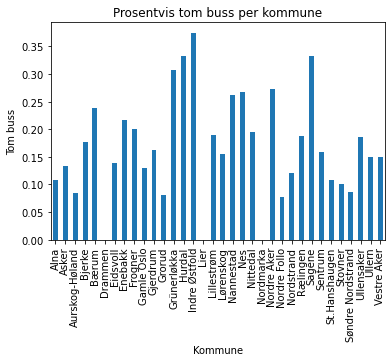

In [27]:
#Lager graf over prosentvis tom buss per kommune
df.groupby(["Kommune"])["Tom_Buss"].mean().plot(ylabel = 'Tom buss', title = 'Prosentvis tom buss per kommune', kind="bar")

<AxesSubplot:title={'center':'Prosent brukte plasser per kommune'}, xlabel='Kommune', ylabel='Prosent brukte plasser'>

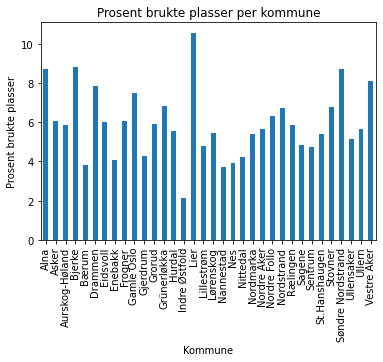

In [28]:
#Lager en graf over prosent brukte plasser per kommune
df.groupby(["Kommune"])["Prosent_Brukte_Plasser"].mean().plot(kind ="bar", ylabel = "Prosent brukte plasser", title="Prosent brukte plasser per kommune")